In [152]:
import os
from dotenv import load_dotenv
import argparse
import re
import pickle
from datetime import timedelta
import google.oauth2.credentials
import google_auth_oauthlib.flow as fl
from googleapiclient.discovery import build
from google.auth.transport.requests import Request
from googleapiclient.errors import HttpError
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [155]:
credentials=None

In [156]:
if os.path.exists('token.pickle'):
    print('Loding Credentials from File...')
    with open('token.pickle','rb') as token:
        credentials=pickle.load(token)

Loding Credentials from File...


In [159]:
if not credentials or not credentials.valid:
    if credentials and credentials.expired and credentials.refresh_token:
        print('Refereshing access token...')
        credentials.refresh(Request())
    else:
        print('Fetching New Tokens...')
        flow=fl.InstalledAppFlow.from_client_secrets_file('client_secret.json',
                                                  scopes=['https://www.googleapis.com/auth/youtube.readonly'])
        flow.run_local_server(port=8080, prompt='consent',authorization_prompt_message='')
        credentials=flow.credentials
        
        with open('token.pickle','wb') as f:
            print('Saving credentials for future use...')
            pickle.dump(credentials,f)
    
    credentials=flow.credentials
    print(credentials.to_json())

In [160]:
#credentials=flow.credentials
#print(credentials.to_json())

NameError: name 'flow' is not defined

In [161]:
youtube=build("youtube","v3",credentials=credentials)

In [12]:
'''try:
    request=youtube.activities().list(
    part='snippet,contentDetails',
    maxResults=25,
    mine=True)
    response=request.execute()
except Exception as e:
    print(f'An error occurred: {e}')'''

"try:\n    request=youtube.activities().list(\n    part='snippet,contentDetails',\n    maxResults=25,\n    mine=True)\n    response=request.execute()\nexcept Exception as e:\n    print(f'An error occurred: {e}')"

In [13]:
'''channel_ids = [item['contentDetails']['subscription']['resourceId']['channelId'] for item in response['items']
               if 'contentDetails' in item
               and 'subscription' in item['contentDetails']
               and 'resourceId' in item['contentDetails']['subscription']
               and item['contentDetails']['subscription']['resourceId'].get('channelId') is not None]
channel_ids'''


"channel_ids = [item['contentDetails']['subscription']['resourceId']['channelId'] for item in response['items']\n               if 'contentDetails' in item\n               and 'subscription' in item['contentDetails']\n               and 'resourceId' in item['contentDetails']['subscription']\n               and item['contentDetails']['subscription']['resourceId'].get('channelId') is not None]\nchannel_ids"

In [162]:
#Pulling all the playlists for my channel

channel_id='UC-B_ggoiilgcbihS-GYBnIA'

playlist_list=youtube.playlists().list(
    part='contentDetails,id,snippet',
    channelId=channel_id,
    maxResults=25
    )
playlist_lists=playlist_list.execute()
#playlist_lists

In [163]:
lst=[]
for item in playlist_lists['items']:
    lst.append({'playlist_id':item['id'],'playlist_name':item['snippet']['title'],'no_of_videos':item['contentDetails']['itemCount']})
#lst

In [164]:
df=pd.DataFrame(lst)
#df

,playlist_id,playlist_name,no_of_videos
0,PL_wgt95pDQnzVdEnWMRAinfvLUUTk-ShS,Food,65
1,PL_wgt95pDQny9d63eRZ8h7djMvxOnsnFR,Devotional,20
2,PL_wgt95pDQnwMmFQz3iA3F20slkUdbHyM,Gym,199
3,PL_wgt95pDQnzqrOSf22kl25ivo4AZY7oN,diet plan,12
4,PL_wgt95pDQnwywGe6nd7C4-Np1IIFKCgD,songs,449
5,FL-B_ggoiilgcbihS-GYBnIA,Favorites,19


Pulling the necessary data for analysis purpose

In [165]:
playlist_id='PL_wgt95pDQnwMmFQz3iA3F20slkUdbHyM'

nextpagetoken=None
while True:
    playlist_vid=youtube.playlistItems().list(
        part='contentDetails,snippet',
        playlistId=playlist_id,
        maxResults=50,
        pageToken=nextpagetoken
        )
    playlist_vids=playlist_vid.execute()

    vid_ids=[]
    for item in playlist_vids['items']:
        vid_ids.append({
                            'video_id':item['contentDetails']['videoId'],
                            'publisheddate':item['contentDetails']['videoPublishedAt'],
                            'video_title':item['snippet']['title'],
                            'videoOwnerChannelTitle':item['snippet']['videoOwnerChannelTitle'],
                            'thumbnail':item['snippet']['thumbnails']['medium']['url']
                        })
    
    nextpagetoken=playlist_vids.get('nextpagetoken')
    
    if not nextpagetoken:
        break
    

df2=pd.DataFrame(vid_ids)

In [166]:
df2.head(3)

,video_id,publisheddate,video_title,videoOwnerChannelTitle,thumbnail
0,OPf0YbXqDm0,2014-11-19T14:00:18Z,Mark Ronson - Uptown Funk (Official Video) ft....,MarkRonsonVEVO,https://i.ytimg.com/vi/OPf0YbXqDm0/mqdefault.jpg
1,ZbZSe6N_BXs,2014-01-08T08:00:01Z,Pharrell Williams - Happy (Video),PharrellWilliamsVEVO,https://i.ytimg.com/vi/ZbZSe6N_BXs/mqdefault.jpg
2,12CeaxLiMgE,2014-05-22T14:00:05Z,"Dillon Francis, DJ Snake - Get Low (Official M...",DillonFrancisVEVO,https://i.ytimg.com/vi/12CeaxLiMgE/mqdefault.jpg


In [167]:
music_category=[]
#music_cat=[]

vid_request=youtube.videos().list(part='topicDetails',
                                    id='k2qgadSvNyU,DyDfgMOUjCI')
vid_response=vid_request.execute()

for item in vid_response['items']:
    video_id = item['id']
    categories = item['topicDetails']['topicCategories']
    category_value = list(set(category.split('/')[-1] for category in categories))
    music_category.append({'id': video_id, 'category_value': category_value})

In [181]:
videos=[]
music_category=[]
while True:    
    
    vid_request=youtube.videos().list(part='statistics,contentDetails,snippet,topicDetails',
                                    id=','.join(item['video_id'] for item in vid_ids))
    vid_response=vid_request.execute()
    
    for item in vid_response['items']:
        vid_views=item['statistics']['viewCount']
        vid_like_count=item['statistics']['likeCount']
        vid_comment_count=item['statistics']['commentCount']
        video_id = item['id']
        yt_link=f'https://youtu.be/{video_id}'
        duration=item['contentDetails']['duration']
        category_id=item['snippet']['categoryId']
        categories =item.get('topicDetails',{}).get('topicCategories',{})
        category_value = list(set(category.split('/')[-1] for category in categories))
        music_category.append({'video_id': video_id, 'category_value': category_value})
        
        videos.append({
                        'views':int(vid_views),
                        'url':yt_link,
                        'video_id':video_id,
                        'video_likes':int(vid_like_count),
                        'video_comments':int(vid_comment_count),
                        'video_category_id':int(category_id)     
                        })
    
    nextpagetoken=playlist_vids.get('nextpagetoken')
    
    if not nextpagetoken:
        break
    
df3=pd.DataFrame(videos)
df4=df2.merge(df3,on='video_id')  
df5=pd.DataFrame(music_category)
df_new=df4.merge(df5,on='video_id')
#df_new.head(3)

In [182]:
df_new['category_value']=df_new['category_value'].apply(','.join)

In [183]:
df_new.duplicated().sum()

0

In [184]:
df_new.head(3)

,video_id,publisheddate,video_title,videoOwnerChannelTitle,thumbnail,views,url,video_likes,video_comments,video_category_id,category_value
0,OPf0YbXqDm0,2014-11-19T14:00:18Z,Mark Ronson - Uptown Funk (Official Video) ft....,MarkRonsonVEVO,https://i.ytimg.com/vi/OPf0YbXqDm0/mqdefault.jpg,5148446341,https://youtu.be/OPf0YbXqDm0,21255513,609078,10,"Hip_hop_music,Pop_music,Music"
1,ZbZSe6N_BXs,2014-01-08T08:00:01Z,Pharrell Williams - Happy (Video),PharrellWilliamsVEVO,https://i.ytimg.com/vi/ZbZSe6N_BXs/mqdefault.jpg,1254753533,https://youtu.be/ZbZSe6N_BXs,8333764,223504,10,"Soul_music,Pop_music,Music"
2,12CeaxLiMgE,2014-05-22T14:00:05Z,"Dillon Francis, DJ Snake - Get Low (Official M...",DillonFrancisVEVO,https://i.ytimg.com/vi/12CeaxLiMgE/mqdefault.jpg,747563232,https://youtu.be/12CeaxLiMgE,5375455,98244,10,"Hip_hop_music,Electronic_music,Music"


Performing some EDA

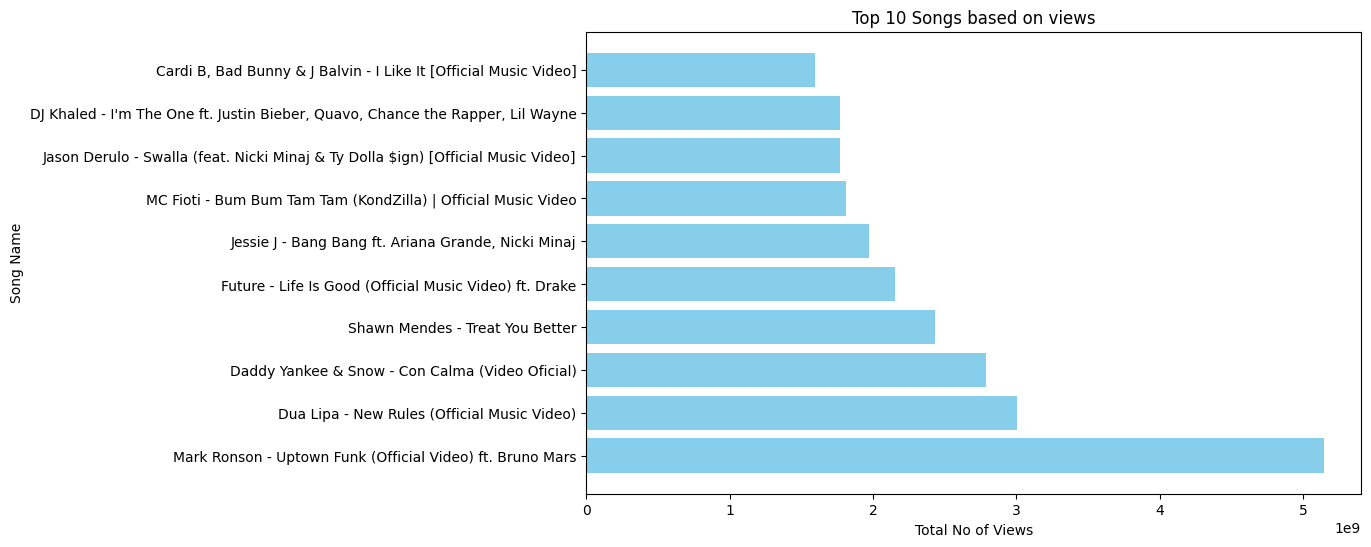

In [172]:
df_sorted = df_new.sort_values(by='views', ascending=False)

# Plot a bar chart for the top 10 values
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['video_title'].head(10), df_sorted['views'].head(10), color='skyblue')
plt.xlabel('Total No of Views')
plt.ylabel('Song Name')
plt.title('Top 10 Songs based on views')
plt.show()

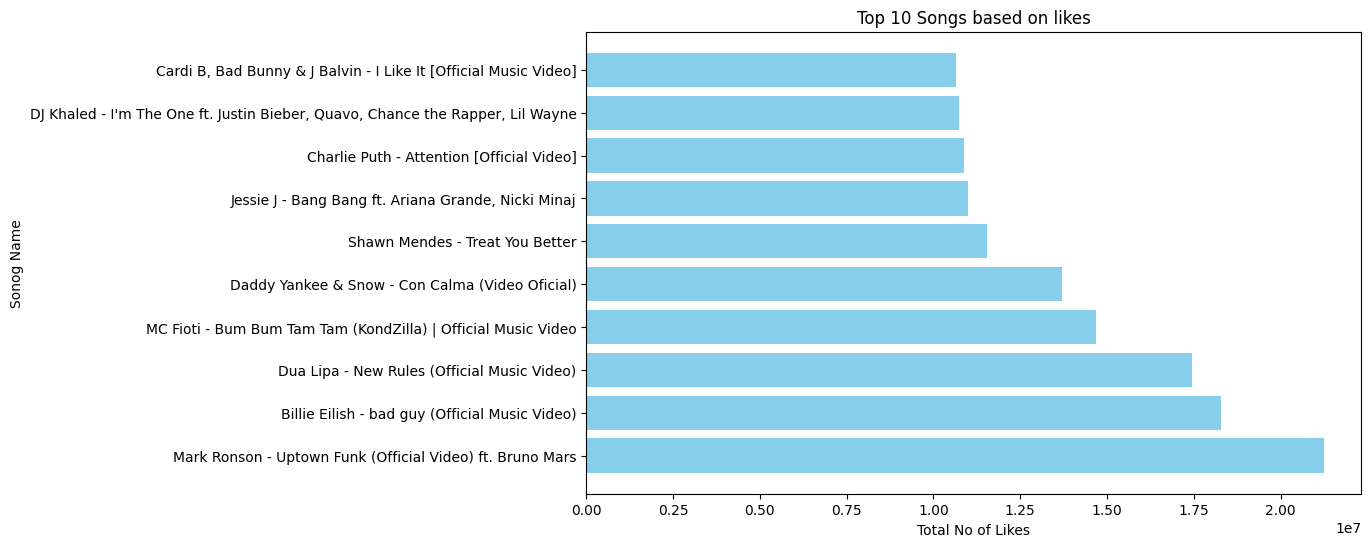

In [173]:
df_sorted2 = df_new.sort_values(by='video_likes', ascending=False)

# Plot a bar chart for the top 10 values
plt.figure(figsize=(10, 6))
plt.barh(df_sorted2['video_title'].head(10), df_sorted2['video_likes'].head(10), color='skyblue')
plt.xlabel('Total No of Likes')
plt.ylabel('Sonog Name')
plt.title('Top 10 Songs based on likes')
plt.show()

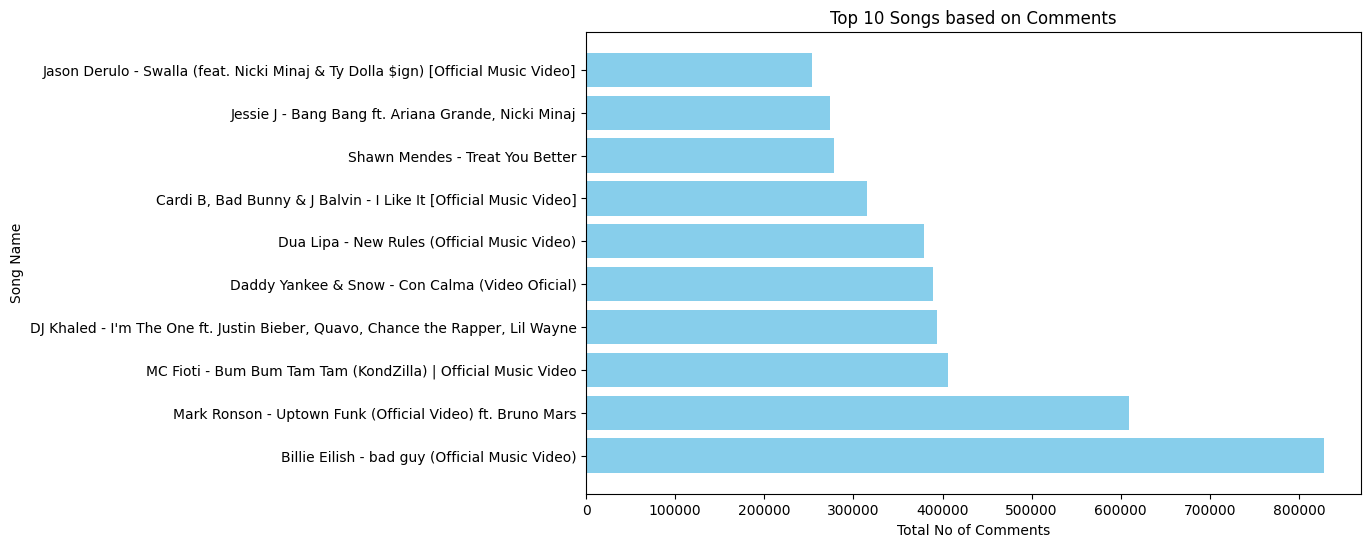

In [174]:
df_sorted3 = df_new.sort_values(by='video_comments', ascending=False)

# Plot a bar chart for the top 10 values
plt.figure(figsize=(10, 6))
plt.barh(df_sorted3['video_title'].head(10), df_sorted3['video_comments'].head(10), color='skyblue')
plt.xlabel('Total No of Comments')
plt.ylabel('Song Name')
plt.title('Top 10 Songs based on Comments')
plt.show()

In [140]:
#df_new['publisheddate'].dtype

dtype('O')

In [185]:
df_new['published_date'] = pd.to_datetime(df_new['publisheddate'])

# Extract yyyy-mm-dd format
df_new['published_date'] = df_new['published_date'].dt.strftime('%Y-%m-%d')

# Drop the original datetime column if needed
df_new.drop(columns=['publisheddate'], inplace=True)


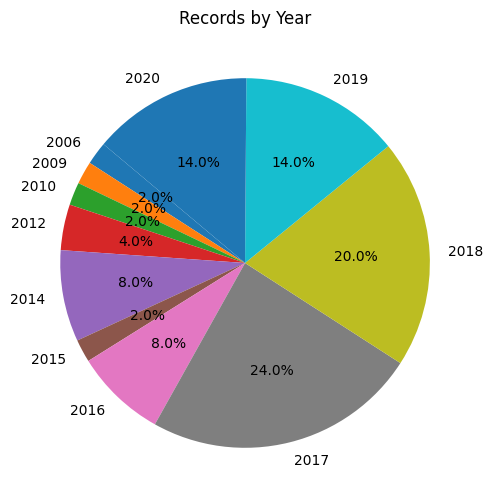

In [176]:
df_new['year'] = pd.to_datetime(df_new['published_date']).dt.year
grouped_df=df_new.groupby(df_new['year']).size()

plt.figure(figsize=(6, 6))
plt.pie(grouped_df, labels=grouped_df.index, autopct='%1.1f%%', startangle=140)
plt.title('Records by Year')
plt.show()

In [193]:
columns_to_normalize=['views','video_likes','video_comments']
data_to_normalize = df_new[columns_to_normalize]

In [194]:
df_new['views'].dtype

dtype('int64')

In [195]:
scaler=MinMaxScaler()

In [196]:
scaler.fit(data_to_normalize)

MinMaxScaler()

In [197]:
df_new[columns_to_normalize]=scaler.transform(data_to_normalize)

In [198]:
'''I created this rating formula where I am giving 50% weightage to views, 
30% weightage to likes and 20% weightage to comments to see top 50 songs in my playlist'''
df_new['Rating']=df_new['views']*0.5+df_new['video_likes']*0.3+df_new['video_comments']*0.2

In [199]:
popular_songs=df_new.sort_values(by='Rating',ascending=False).head(50)

In [200]:
popular_songs.head(3)

,video_id,video_title,videoOwnerChannelTitle,thumbnail,views,url,video_likes,video_comments,video_category_id,category_value,published_date,Rating
0,OPf0YbXqDm0,Mark Ronson - Uptown Funk (Official Video) ft....,MarkRonsonVEVO,https://i.ytimg.com/vi/OPf0YbXqDm0/mqdefault.jpg,1.000000,https://youtu.be/OPf0YbXqDm0,1.000000,0.735196,10,"Hip_hop_music,Pop_music,Music",2014-11-19,0.947039
32,k2qgadSvNyU,Dua Lipa - New Rules (Official Music Video),Dua Lipa,https://i.ytimg.com/vi/k2qgadSvNyU/mqdefault.jpg,0.583751,https://youtu.be/k2qgadSvNyU,0.821390,0.457419,10,"Pop_music,Music",2017-07-07,0.629776
21,DyDfgMOUjCI,Billie Eilish - bad guy (Official Music Video),BillieEilishVEVO,https://i.ytimg.com/vi/DyDfgMOUjCI/mqdefault.jpg,0.246837,https://youtu.be/DyDfgMOUjCI,0.860275,1.000000,10,"Pop_music,Music",2019-03-29,0.581501
